### Clustering
> Everything should be made as simple as possible, but not simpler. - Albert Einstein

- Sometimes, world issues are best understood as multivariate. ex:
	- percentage of foreign-born vs what is a neighborhood
	- years of schooling vs human development
	- monthly income vs deprivation

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster

/home/pdb/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Our goal in this notebook is to create a classification of areas (MSOAs) in Inner London based on the ratings of the AirBnb locations

In [2]:
# Read the file in
abb = gpd.read_file(
    "https://darribas.org/gds_course/content/data/london_abb.gpkg"
)

<Axes: >

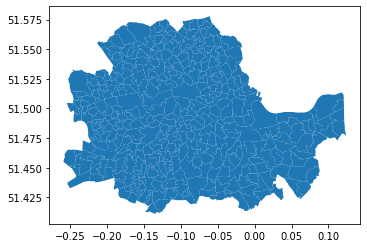

In [3]:
abb.plot()

In [4]:
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

In [ ]:
ratings = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]

In [6]:
boroughs = gpd.read_file(
    "https://darribas.org/gds_course/content/data/london_inner_boroughs.geojson"
)

<Axes: >

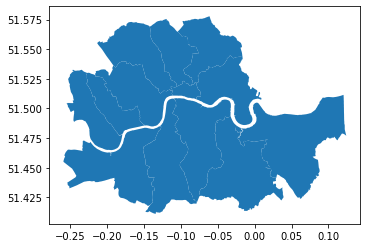

In [8]:
boroughs.plot()

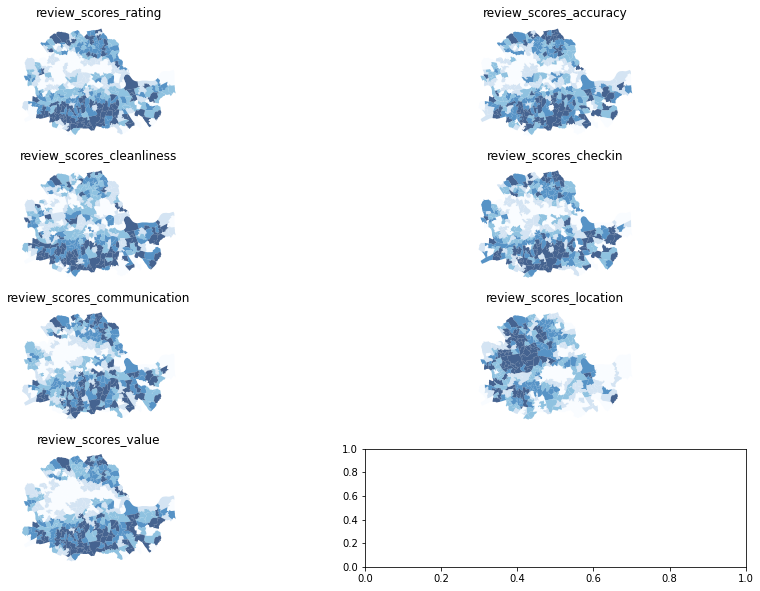

In [ ]:
f, axs = plt.subplots(4, 2, figsize=(15, 10))
axs = axs.flatten()

for i, rating in enumerate(ratings):
    abb.plot(ax=axs[i],
             column=rating,
             scheme='Quantiles',
            cmap='Blues',
            alpha=0.75)
    axs[i].set_axis_off()
    axs[i].set_title(rating)
plt.show()

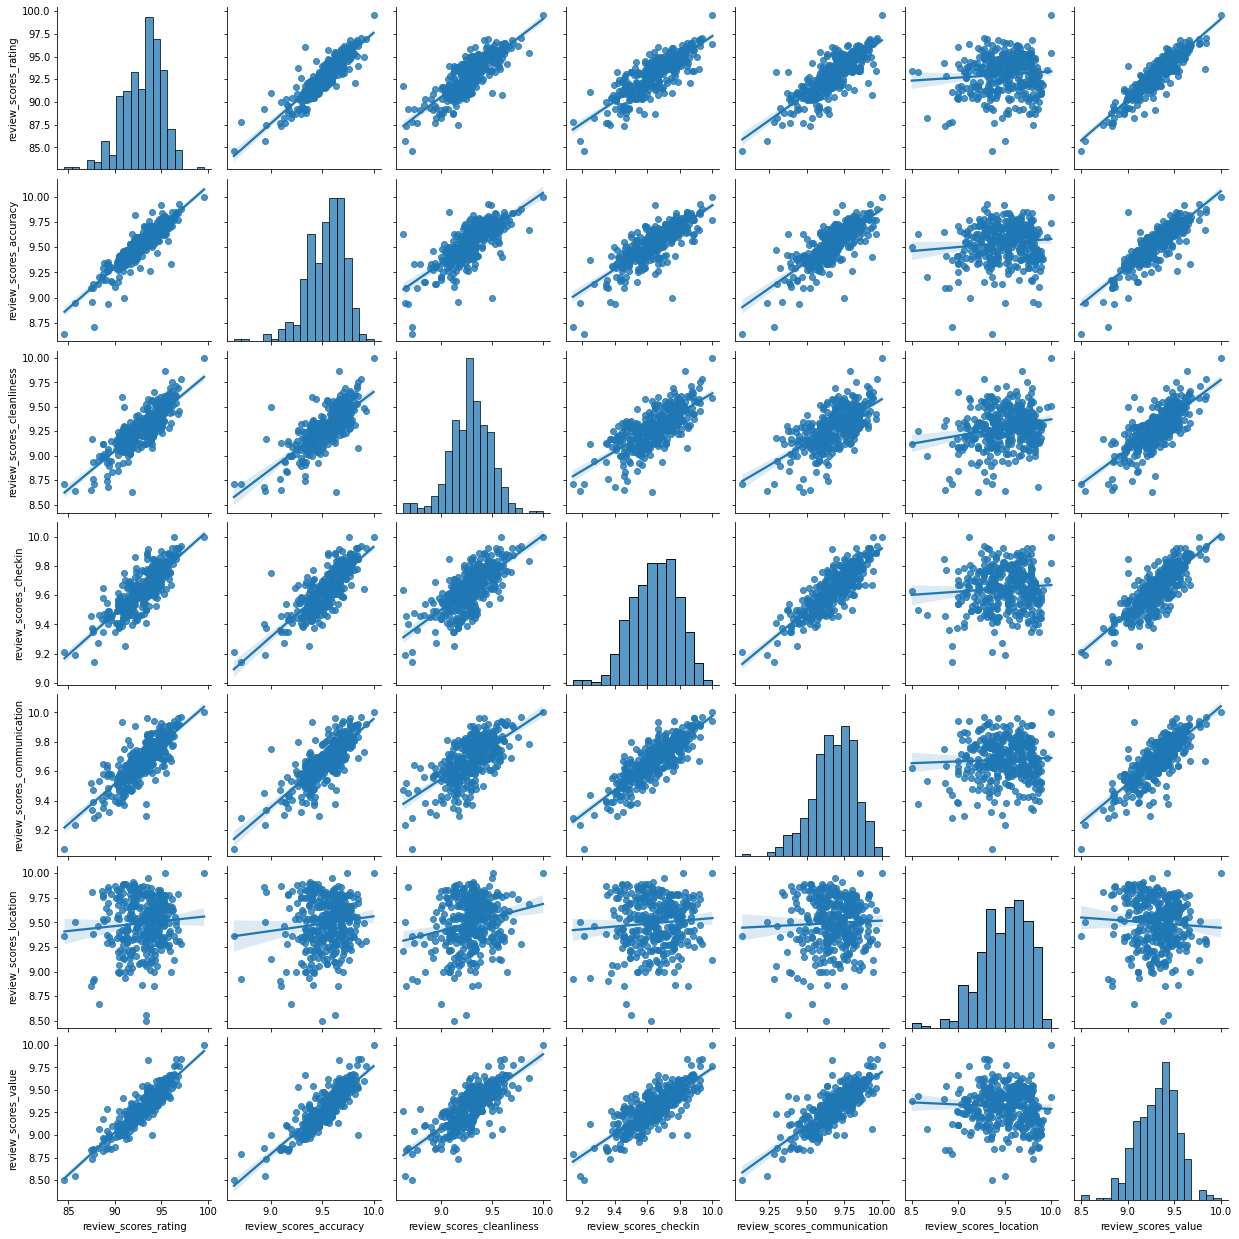

In [19]:
_ = sns.pairplot(abb[ratings], kind='reg', diag_kind='hist')

### An AirBnb geodemographic classification of Inner London using K-means
K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will use five

In [41]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=12345)

In [ ]:
ratings = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]
k5cls = kmeans5.fit(abb[ratings])

In [39]:
abb['k5cls'] = k5cls.labels_

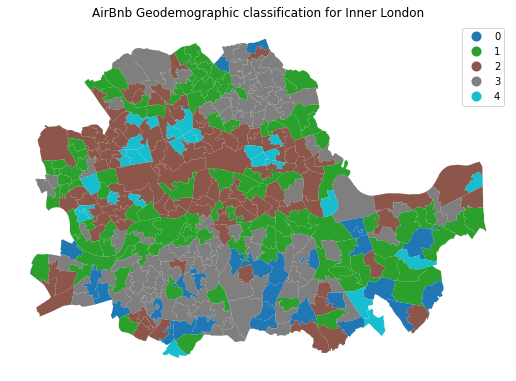

In [40]:
f, ax = plt.subplots(1, figsize=(9, 9))

abb.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax,
)

ax.set_axis_off()
plt.title('AirBnb Geodemographic classification for Inner London')
plt.show()

In [29]:
k5sizes = abb.groupby('k5cls').size()
k5sizes

k5cls
0     28
1    103
2    102
3     94
4     26
dtype: int64

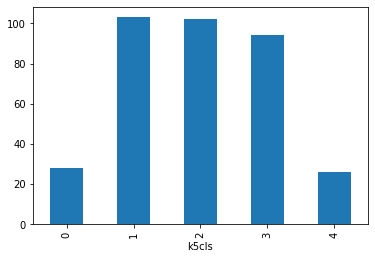

In [30]:
_ = k5sizes.plot.bar()

In [42]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[ratings].mean()
k5means.T

k5cls,0,1,2,3,4
review_scores_rating,96.278785,93.360972,91.322079,94.773913,88.468826
review_scores_accuracy,9.764237,9.577598,9.407599,9.682225,9.156232
review_scores_cleanliness,9.575961,9.305514,9.164816,9.420684,8.915268
review_scores_checkin,9.851993,9.657893,9.545119,9.744665,9.417369
review_scores_communication,9.859531,9.694302,9.583235,9.774913,9.453563
review_scores_location,9.479677,9.471527,9.495194,9.527138,9.455189
review_scores_value,9.643258,9.347262,9.146983,9.471397,8.908922


## Regionalization algorithms

Areas that are spatially contiguous

Combines ML with geography. Aggregating basic spatial units (areas) into larger units (regions)

1. It needs to aggregate geographical areas into a predefined number of regions, optimizing a particular aggregation criteria
2. Areas within a region must be geographically connected (spatial contiguity constraint)
3. The number of regions must be smaller or equal to the number of areas
4. Each area must be assigned to one and only one region
5. Each region must contain at least one area

**Algorithms (Duque et al (2007) to continue to learn regionalization)**
- Arisel
- AZP Automated Zoning Procedure
- Max-P

**Examples**
1. Census geographies
2. Livehoods

In [43]:
w = weights.Queen.from_dataframe(abb)

/tmp/ipykernel_10618/2521922249.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(abb)


In [44]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)

sagg13cls = sagg13.fit(abb[ratings])

abb['sagg13cls'] = sagg13cls.labels_

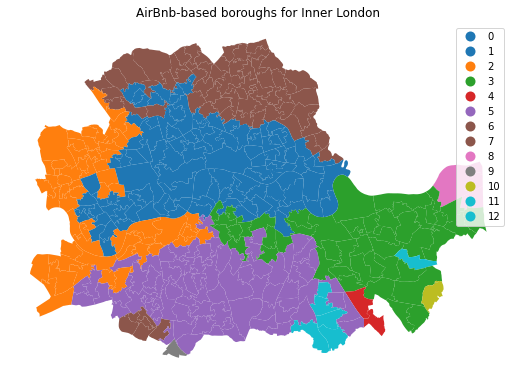

In [45]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))

abb.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax
)

ax.set_axis_off()
plt.title('AirBnb-based boroughs for Inner London')
plt.show()

In [ ]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one

    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

In [47]:
# Dissolve the polygons based on `sagg13cls`
abb_boroughs = gpd.GeoSeries(
    abb.groupby(abb['sagg13cls']).apply(dissolve),
    crs=abb.crs
)

/tmp/ipykernel_10618/4065700530.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  abb.groupby(abb['sagg13cls']).apply(dissolve),


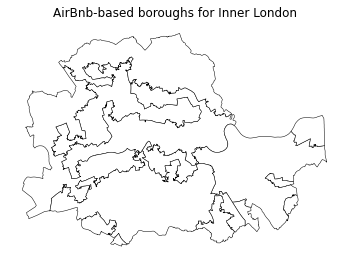

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
abb_boroughs.plot(
    ax=ax,
    linewidth=0.5,
    facecolor='white',
    edgecolor='k'
)
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London');

Now let’s compare this geography that we have organically drawn from our data with that of the official set of administrative boundaries

In [54]:
boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Lambeth,E09000022,2724.940,43.927,T,None,None,"POLYGON ((-0.12846 51.48505, -0.12843 51.48506..."
1,Southwark,E09000028,2991.340,105.139,T,None,None,"POLYGON ((-0.10892 51.50844, -0.10889 51.50845..."
2,Lewisham,E09000023,3531.706,16.795,T,None,None,"POLYGON ((-0.03241 51.49306, -0.03240 51.49303..."
3,Greenwich,E09000011,5044.190,310.785,F,None,None,"MULTIPOLYGON (((-0.02485 51.48555, -0.02479 51..."
4,Wandsworth,E09000032,3522.022,95.600,T,None,None,"POLYGON ((-0.22343 51.47152, -0.22327 51.47146..."


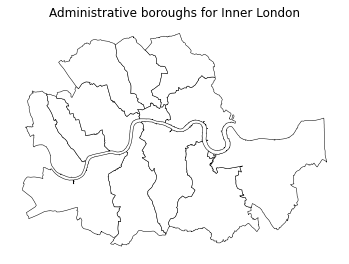

In [ ]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
boroughs.plot(
    ax=ax,
    linewidth=0.5,
    edgecolor='k',
    facecolor='white'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Administrative boroughs for Inner London');

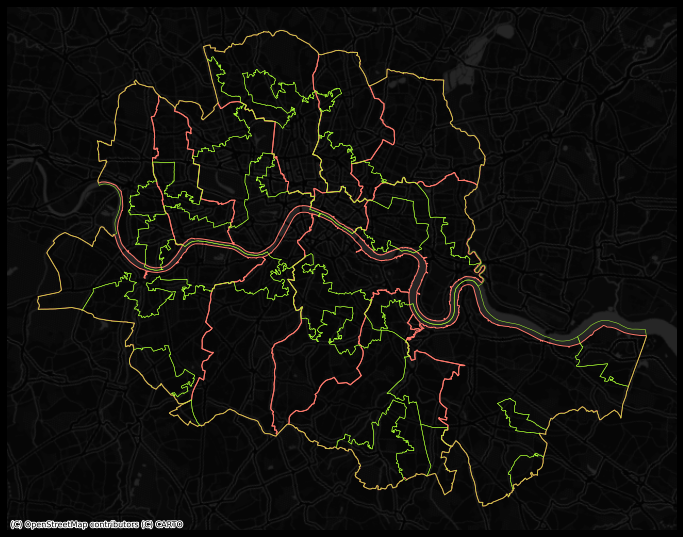

In [56]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("k")

# Add boroughs
boroughs.to_crs(
    epsg=22770
).plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:salmon",
    linewidth=1
)

# Add regionalisation geography
abb_boroughs.to_crs(
    epsg=22770
).plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:lime",
    linewidth=0.5
)

# Add basemap
cx.add_basemap(
    ax,
    crs="EPSG:22770",
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()

# Do-It-Yourself 

### Task I: NYC Geodemographics

1. Pick a number of clusters (e.g. 10)

2. Run K-Means for that number of clusters

3. Plot the different clusters on a map

4. Analyse the results:
    - What do you find?
    - What are the main characteristics of each cluster?
    - How are clusters distributed geographically?
    - Can you identify some groups concentrated on particular areas (e.g. China Town, Little Italy)?

In [59]:
import geopandas
import contextily
from pysal.lib import weights
import matplotlib.pyplot as plt
from pysal.lib import examples
from sklearn import cluster
import matplotlib.patches as mpatches

In [22]:
nyc_data = examples.load_example("NYC Socio-Demographics")
nyc_data.get_file_list()

['/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.dbf',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shx',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shp',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.prj',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shp',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shx',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj',
 '/home/pdb/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.dbf']

In [23]:
nyc = geopandas.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

In [44]:
columns = ['european', 'asian', 'american', 'african', 'hispanic', 'mixed', 'pacific']

for c in columns:
    print(c, nyc[c].mean())

european 1683.370729455217
asian 486.44921514312097
american 14.193444136657433
african 950.7289935364728
hispanic 1081.9289012003694
mixed 108.99445983379502
pacific 1.7848568790397046


In [45]:
kmeans5 = cluster.KMeans(n_clusters=10, random_state=12345)

nacionalities = kmeans5.fit(nyc[columns])

In [46]:
nyc['origin'] = nacionalities.labels_

In [47]:
nyc = nyc.set_crs(epsg=3857)

/home/pdb/.local/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


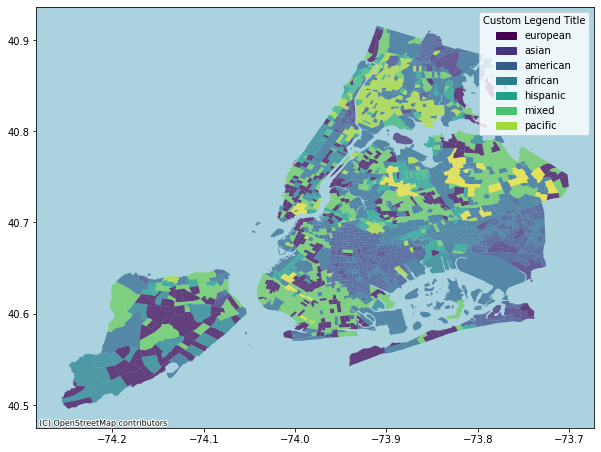

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))
nyc.plot(ax=ax,
         column='origin',
         cmap='viridis',
         alpha=0.7,
         categorical=True,
         legend=True)

category_to_label = {k: v for k, v in zip(list(range(0, 7)), columns)}

# Create custom legend handles
handles = [mpatches.Patch(color=plt.cm.viridis(i / len(category_to_label)), label=label)
           for i, (category, label) in enumerate(category_to_label.items())]

# Add the custom legend to the plot
ax.legend(handles=handles, title='Custom Legend Title')

contextily.add_basemap(ax=ax, source=contextily.providers.OpenStreetMap.Mapnik)

## Task II: Regionalisation of Dar Es Salaam

In [ ]:
# Read the file in
db = geopandas.read_file(
    "http://darribas.org/gds_course/content/data/dar_es_salaam.geojson"
)

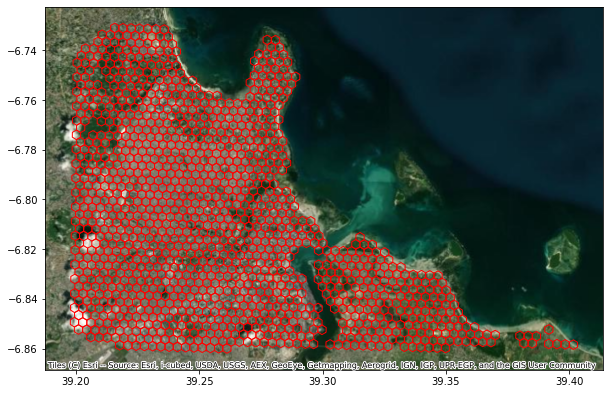

In [ ]:
ax = db.plot(facecolor='none',
            edgecolor='r',
            figsize=(10, 10))
contextily.add_basemap(ax=ax, crs=db.crs, source=contextily.providers.Esri.WorldImagery)

In [57]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   index              1291 non-null   object  
 1   id                 1291 non-null   object  
 2   street_length      1291 non-null   float64 
 3   street_linearity   1291 non-null   float64 
 4   building_density   1291 non-null   float64 
 5   building_coverage  1291 non-null   float64 
 6   geometry           1291 non-null   geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 70.7+ KB


In [60]:
w = weights.Queen.from_dataframe(db)

/tmp/ipykernel_79360/3703584293.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(db)
/home/pdb/.local/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 87.
  W.__init__(self, neighbors, ids=ids, **kw)


In [80]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w.sparse)

sagg13cls = sagg13.fit(db[['street_length', 'street_linearity', 'building_density', 'building_coverage']])
db['boundaries'] = sagg13cls.labels_

/home/pdb/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


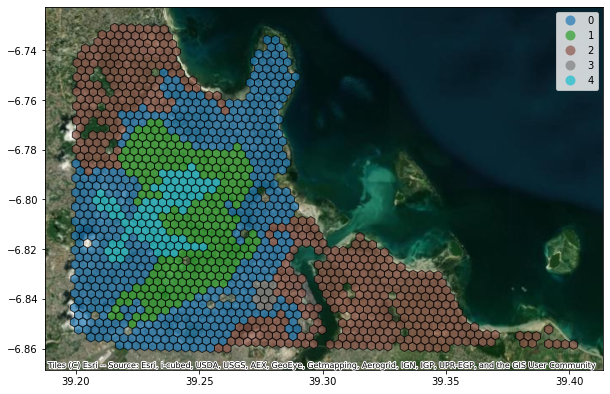

In [ ]:
ax = db.plot(column='boundaries',
             categorical=True,
             legend=True,
             alpha = 0.7,
             edgecolor='k',
            figsize=(10, 10))

contextily.add_basemap(ax=ax,
                      crs=db.crs,
                      source=contextily.providers.Esri.WorldImagery)